# ⚖️ Non-IID Client Data Distribution
This notebook simulates a Non-IID data distribution across clients by skewing label proportions. Useful for evaluating the robustness of federated learning models under real-world heterogeneity.

---

[INFO] ✅ Total GOOD files found: 1935
[INFO] ✅ Total BAD  files found: 1980

[INFO] 🎯 Reserving 100 GOOD and 100 BAD files for the test set...
[INFO] ✍️ Saving test files to '../../resources/material/train-data/federated/non-IID/test_clients' and writing test label CSV...
[INFO] ✅ Test set created with total: 100 GOOD + 100 BAD = 200 files

[INFO] 📁 client_1: 733 GOOD (80.0%) + 183 BAD (20.0%) — Skew Target → GOOD: 80%, BAD: 20%
[INFO] 📁 client_2: 641 GOOD (70.0%) + 275 BAD (30.0%) — Skew Target → GOOD: 70%, BAD: 30%
[INFO] 📁 client_3: 458 GOOD (50.0%) + 458 BAD (50.0%) — Skew Target → GOOD: 50%, BAD: 50%
[INFO] 📁 client_4: 3 GOOD (0.5%) + 641 BAD (99.5%) — Skew Target → GOOD: 30%, BAD: 70%
[INFO] 📁 client_5: 0 GOOD (0.0%) + 323 BAD (100.0%) — Skew Target → GOOD: 20%, BAD: 80%

[SUMMARY]
🟢 Total GOOD files used: 1935 / 1935
🔴 Total BAD  files used: 1980 / 1980
🧪 Test set: 100 GOOD + 100 BAD
👤 client_1: 733 GOOD + 183 BAD
👤 client_2: 641 GOOD + 275 BAD
👤 client_3: 458 GOOD + 458 BAD
👤 c

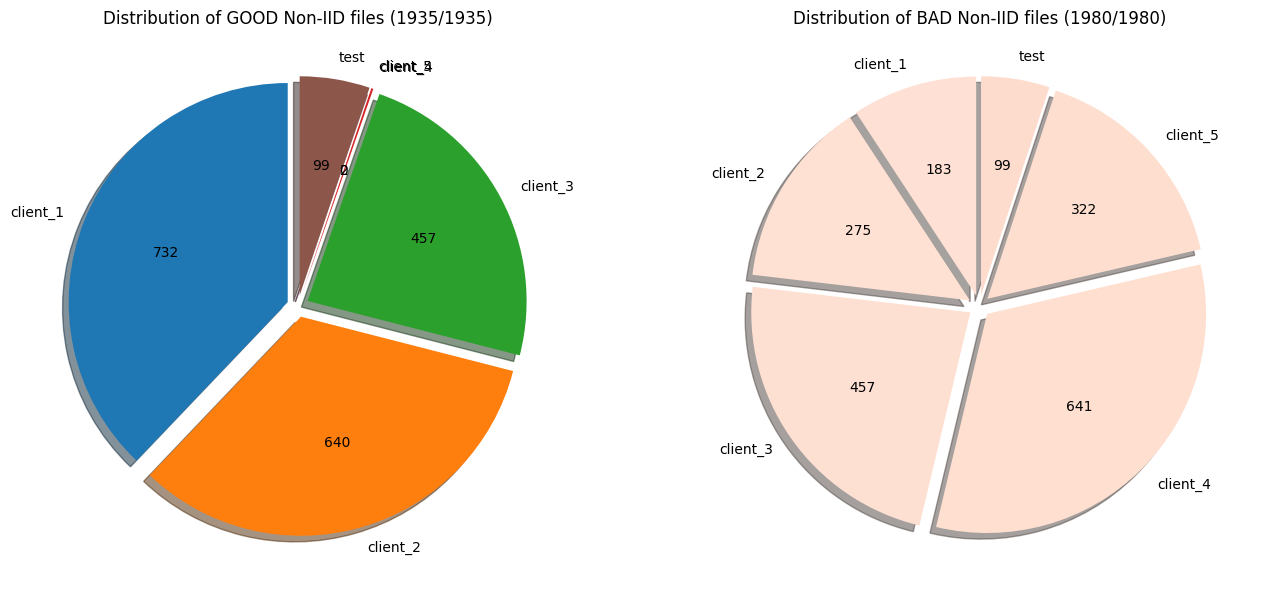

In [1]:
import os
import shutil
import random
from pathlib import Path
from typing import List
import matplotlib.pyplot as plt


def list_wav_files(directory: str) -> List[str]:
    return sorted([f for f in os.listdir(directory) if f.endswith(".wav")])


def distribute_non_iid_clients_with_test(
    good_dir: str,
    bad_dir: str,
    output_base_dir: str,
    num_clients: int = 5,
    test_samples_per_class: int = 100,
    seed: int = 42
):
    random.seed(seed)
    output_base = Path(output_base_dir)
    test_dir = output_base / "test_clients"
    test_dir.mkdir(parents=True, exist_ok=True)

    # === Step 1: Load files ===
    good_files = list_wav_files(good_dir)
    bad_files = list_wav_files(bad_dir)

    original_good = len(good_files)
    original_bad = len(bad_files)
    print(f"[INFO] ✅ Total GOOD files found: {original_good}")
    print(f"[INFO] ✅ Total BAD  files found: {original_bad}")

    # === Step 2: Extract Test Set ===
    print(f"\n[INFO] 🎯 Reserving {test_samples_per_class} GOOD and {test_samples_per_class} BAD files for the test set...")

    random.shuffle(good_files)
    random.shuffle(bad_files)
    test_good = good_files[:test_samples_per_class]
    test_bad = bad_files[:test_samples_per_class]
    good_files = good_files[test_samples_per_class:]
    bad_files = bad_files[test_samples_per_class:]

    print(f"[INFO] ✍️ Saving test files to '{test_dir}' and writing test label CSV...")
    with open(test_dir / "labels.csv", "w") as f:
        f.write("filename,label\n")
        for file in test_good:
            shutil.copy2(Path(good_dir) / file, test_dir / file)
            f.write(f"{file},good\n")
        for file in test_bad:
            shutil.copy2(Path(bad_dir) / file, test_dir / file)
            f.write(f"{file},bad\n")

    print(f"[INFO] ✅ Test set created with total: {len(test_good)} GOOD + {len(test_bad)} BAD = {len(test_good) + len(test_bad)} files\n")

    # === Step 3: Simulate Non-IID Skew Per Client ===
    client_skews = [
        {"good": 0.8, "bad": 0.2}, # Client 1 → 90% good, 10% bad
        {"good": 0.7, "bad": 0.3}, # Client 2 → 10% good, 90% bad
        {"good": 0.5, "bad": 0.5}, # Client 3 → 50/50
        {"good": 0.3, "bad": 0.7}, # Client 4 → 70% good, 30% bad
        {"good": 0.2, "bad": 0.8}, # Client 5 → 30% good, 70% bad
    ]
    max_files_per_client = min(len(good_files), len(bad_files)) // 2

    client_distribution = {}

    for i in range(num_clients):
        client_id = f"client_{i+1}"
        client_dir = output_base / client_id
        (client_dir / "good").mkdir(parents=True, exist_ok=True)
        (client_dir / "bad").mkdir(parents=True, exist_ok=True)

        good_fraction = client_skews[i]["good"]
        bad_fraction = client_skews[i]["bad"]
        num_files = max_files_per_client

        num_good = int(num_files * good_fraction)
        num_bad = int(num_files * bad_fraction)

        good_subset = good_files[:num_good]
        bad_subset = bad_files[:num_bad]
        good_files = good_files[num_good:]
        bad_files = bad_files[num_bad:]

        for f in good_subset:
            shutil.copy2(Path(good_dir) / f, client_dir / "good" / f)
        for f in bad_subset:
            shutil.copy2(Path(bad_dir) / f, client_dir / "bad" / f)

        client_distribution[client_id] = {"good": len(good_subset), "bad": len(bad_subset)}
        
        actual_total = len(good_subset) + len(bad_subset)
        actual_good_pct = (len(good_subset) / actual_total * 100) if actual_total > 0 else 0
        actual_bad_pct = (len(bad_subset) / actual_total * 100) if actual_total > 0 else 0

        print(
            f"[INFO] 📁 {client_id}: "
            f"{len(good_subset)} GOOD ({actual_good_pct:.1f}%) + "
            f"{len(bad_subset)} BAD ({actual_bad_pct:.1f}%) — "
            f"Skew Target → GOOD: {good_fraction*100:.0f}%, BAD: {bad_fraction*100:.0f}%"
        )


    # === Summary Print ===
    total_used_good = len(test_good) + sum(v["good"] for v in client_distribution.values())
    total_used_bad = len(test_bad) + sum(v["bad"] for v in client_distribution.values())

    print(f"\n[SUMMARY]")
    print(f"🟢 Total GOOD files used: {total_used_good} / {original_good}")
    print(f"🔴 Total BAD  files used: {total_used_bad} / {original_bad}")
    print(f"🧪 Test set: {len(test_good)} GOOD + {len(test_bad)} BAD")
    for client, counts in client_distribution.items():
        print(f"👤 {client}: {counts['good']} GOOD + {counts['bad']} BAD")

    return {
        "original_good": original_good,
        "original_bad": original_bad,
        "test_good": len(test_good),
        "test_bad": len(test_bad),
        "clients": client_distribution
    }


def plot_distribution_pies(summary):
    labels = list(summary["clients"].keys()) + ["test"]
    good_sizes = [summary["clients"][k]["good"] for k in summary["clients"]]
    bad_sizes = [summary["clients"][k]["bad"] for k in summary["clients"]]
    good_sizes.append(summary["test_good"])
    bad_sizes.append(summary["test_bad"])

    total_good_used = sum(good_sizes)
    total_bad_used = sum(bad_sizes)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    explode = [0.05]*len(labels)

    axs[0].pie(
        good_sizes,
        labels=labels,
        autopct=lambda p: f'{int(p * total_good_used / 100)}',
        explode=explode,
        startangle=90,
        shadow=True
    )
    axs[0].set_title(f"Distribution of GOOD Non-IID files ({total_good_used}/{summary['original_good']})")

    axs[1].pie(
        bad_sizes,
        labels=labels,
        autopct=lambda p: f'{int(p * total_bad_used / 100)}',
        explode=explode,
        startangle=90,
        shadow=True,
        colors=plt.cm.Reds(range(30, 30 + len(labels)*5))
    )
    axs[1].set_title(f"Distribution of BAD Non-IID files ({total_bad_used}/{summary['original_bad']})")

    plt.tight_layout()
    plt.show()


# === Run the Non-IID Distribution ===
summary = distribute_non_iid_clients_with_test(
    good_dir="../../resources/material/train-data/augmented-good-material-taps",
    bad_dir="../../resources/material/train-data/augmented-bad-material-taps",
    output_base_dir="../../resources/material/train-data/federated/non-IID",
    num_clients=5,
    test_samples_per_class=100
)

plot_distribution_pies(summary)
